## Download and import python libraries

In [1]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-uob7qigc
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-uob7qigc
  Resolved https://github.com/facebookresearch/detectron2.git to commit 9604f5995cc628619f0e4fd913453b4d7d61db3f
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.2/79.2 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 48.2 MB/s eta 0:00:00:00:01
  Created wheel for detectron2: filename=detectron2-0.6-cp310-cp310-linux_x86_64.whl size=6345231 sha256=299cbac95f71a314c52e27de73c97f6b7875abf9ff7c41f14c3861b700509136
  Stored in directory: /tmp/pip-ephem-wheel-cache-umf6wd0h/wheels/47/e5/15/94c80df2ba8

In [2]:
# Core libraries
import os
import random
import numpy as np
import cv2
import pandas as pd

# Visualization libraries 
import matplotlib.pyplot as plt
from PIL import Image
import imutils
from imutils import contours
from random import choices, sample
from numpy import *

# Data processing libraries
from scipy.spatial import ConvexHull
from scipy.spatial.distance import cdist
from skimage import measure
from glob import glob
from tqdm.auto import tqdm

# Detectron2 related
import detectron2
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg

# Geometry related
from shapely.geometry import Polygon as shapelyPolygon

In [3]:
# same_seeds(1314)
def compare_masks(label_mask, mask):
    # Convert label_mask to binary if it's not already
    if len(label_mask.shape) == 3:
        if label_mask.shape[2] == 4:  # 如果有alpha通道
            # 将BGRA转换为灰度图
            bgr = label_mask[:,:,0:3]
            alpha = label_mask[:,:,3]
            gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
            # 结合alpha通道和灰度值
            label_mask = np.logical_and(gray > 1, alpha > 1)
        else:
            label_mask = np.all(label_mask == 255, axis=2)
    else:
        label_mask = label_mask > 1
    
    # Count white pixels in label_mask
    total_white_pixels = np.sum(label_mask)

    # Ensure mask is binary
    if len(mask.shape) == 3:
        mask = np.all(mask == 255, axis=2)
    else:
        mask = mask > 127

    # Calculate matching white pixels
    matching_pixels = np.sum(label_mask & mask)

    # Calculate match percentage
    match_percentage = (matching_pixels / total_white_pixels) * 100 if total_white_pixels > 0 else 0

    return match_percentage

In [4]:
class GCM:
    def __init__(self, path, label_dir):
        self.path = path
        self.label_dir = label_dir

    def myRound(self, n):
        answer = round(n)
        if not answer % 2:
            return answer
        if abs(answer + 1 - n) < abs(answer - 1 - n):
            return answer + 1
        else:
            return answer - 1

    def gradient_Convergence(self, sum_data, range_low, range_high, batchsize, learning_rate, weight):
        n = abs(sum_data / batchsize - (range_low + range_high) / 2) * learning_rate * weight

        if sum_data / batchsize > (range_low + range_high) / 2 and (range_low + self.myRound(n)) < range_high:
            range_low = range_low + self.myRound(n)
        elif sum_data / batchsize < (range_low + range_high) / 2 and (range_high - self.myRound(n)) > range_low:
            range_high = range_high - self.myRound(n)

        return range_low, range_high

    def shape_Detection(self, blocksize, C, pixel_limits, thresh_2, tileGridSize, gsize):
        global match_limit
    
        image = cv2.imread(self.path)
        image_copy = image.copy()
        imgGray = cv2.imread(self.path, flags=0)
        clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(tileGridSize, tileGridSize))
        img_norm = clahe.apply(imgGray)

        thresh = cv2.adaptiveThreshold(img_norm, 520, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, blocksize, C)
        blurred = cv2.GaussianBlur(thresh, (gsize, gsize), 0)
        thresh = cv2.threshold(blurred, thresh_2, 255, cv2.THRESH_BINARY)[1]

        labels = measure.label(thresh, connectivity=None, background=0)
        mask = np.zeros(thresh.shape, dtype="uint8")

        for label in np.unique(labels):
            if label == 0:
                continue
            labelMask = np.zeros(thresh.shape, dtype="uint8")
            labelMask[labels == label] = 255
            numPixels = cv2.countNonZero(labelMask)
            if numPixels > pixel_limits:
                mask = cv2.add(mask, labelMask)
                
        area_list = []

        cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        mskcnts, hierarchy = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
        cnts = imutils.grab_contours(cnts)
        
#         print(len(cnts))
        
        if cnts:
            cnts = sorted(cnts, key=lambda c: cv2.boundingRect(c)[0])
                # loop over the contours

            for (i, c) in enumerate(cnts):
                    # draw the bright spot on the image
                (x, y, w, h) = cv2.boundingRect(c)
                ((cX, cY), radius) = cv2.minEnclosingCircle(c)
                area_list = np.append(area_list, radius)
                cv2.drawContours(image_copy, mskcnts, -1, (0, 0, 255), 1)
                cv2.circle(image, (int(cX), int(cY)), int(radius),
                               (0, 0, 255), 1)

        else:
            i = 0

        dot_num = i

        # Construct label path
        filename, ext = os.path.splitext(os.path.basename(self.path))
        label_ext = os.path.splitext(os.path.basename(os.listdir(self.label_dir)[0]))[1]
        label_path = os.path.join(self.label_dir, f"{filename}{label_ext}")
#         print(label_path)
        label_mask = cv2.imread(label_path, cv2.IMREAD_UNCHANGED)
        match_percentage = compare_masks(label_mask, mask)
    
        match = match_percentage > match_limit
#         if match: 
#             print('match')
    
        return dot_num, mask, match

    def train(self, epoch, batchsize, lower_limit, upper_limit, learning_rate, weight,
              blocksize_range_down, blocksize_range_up,
              C_list_range_down, C_list_range_up,
              pixel_limits_range_range_down, pixel_limits_range_range_up,
              blurred_range_down, blurred_range_up, thresh_2_range_down, thresh_2_range_up,
              tileGridSize_range_down, tileGridSize_range_up):
        global match_limit

        for i in range(epoch):
            
            positive_data = 0
            range_hat_list = sample(range(batchsize), k=batchsize)
            blocksize_range = arange(blocksize_range_down, blocksize_range_up + 2, 2)
            blocksize_list = choices(blocksize_range, k=batchsize)
            C_list = np.random.randint(C_list_range_down, C_list_range_up + 1, size=batchsize + 1)
            pixel_limits_range = arange(pixel_limits_range_range_down, pixel_limits_range_range_up + 1, 1)
            pixel_limits_list = choices(pixel_limits_range, k=batchsize)
            thresh_2_range = arange(thresh_2_range_down, thresh_2_range_up + 1, 1)
            thresh_2_list = choices(thresh_2_range, k=batchsize)
            tileGridSize_range = arange(tileGridSize_range_down, tileGridSize_range_up + 1, 1)
            tileGridSize_list = choices(tileGridSize_range, k=batchsize)
            blurred_range = arange(blurred_range_down, blurred_range_up + 2, 2)
            blurred_list = choices(blurred_range, k=batchsize)

            for j in tqdm(range(batchsize)):
                range_hat = range_hat_list[j]
                pixel_limits = pixel_limits_list[range_hat]
                C = C_list[range_hat]
                thresh_2 = thresh_2_list[range_hat]
                blocksize = blocksize_list[range_hat]
                tileGridSize = tileGridSize_list[range_hat]
                gsize = blurred_list[range_hat]

                dot_num, mask, match = self.shape_Detection(blocksize, C, pixel_limits, thresh_2, tileGridSize, gsize)

                if (dot_num > lower_limit) and (dot_num < upper_limit) and match:
                    positive_data += 1
                    datasize = 1
                    sum_C = int(C)
                    sum_B = int(blocksize)
                    sum_P = int(pixel_limits)
                    sum_G = gsize
                    sum_R = tileGridSize
                    sum_T = int(thresh_2)

                    C_list_range_down, C_list_range_up = self.gradient_Convergence(sum_C, C_list_range_down, C_list_range_up, datasize, learning_rate, weight)
                    blocksize_range_down, blocksize_range_up = self.gradient_Convergence(sum_B, blocksize_range_down, blocksize_range_up, datasize, learning_rate, weight)
                    pixel_limits_range_range_down, pixel_limits_range_range_up = self.gradient_Convergence(sum_P, pixel_limits_range_range_down, pixel_limits_range_range_up, datasize, learning_rate, weight)
                    blurred_range_down, blurred_range_up = self.gradient_Convergence(sum_G, blurred_range_down, blurred_range_up, datasize, learning_rate, weight)
                    tileGridSize_range_down, tileGridSize_range_up = self.gradient_Convergence(sum_R, tileGridSize_range_down, tileGridSize_range_up, datasize, learning_rate, weight)
                    thresh_2_range_down, thresh_2_range_up = self.gradient_Convergence(sum_T, thresh_2_range_down, thresh_2_range_up, datasize, learning_rate, weight)
                    
            match_limit += (80 - match_limit_num )/epoch
            print('match_limit = ',match_limit)

            loss = 1 - positive_data / batchsize

            print(loss)
            print(f"{i}/{epoch}")
            if loss < 0.3 and match:
                break

        return blocksize, C, pixel_limits, thresh_2, tileGridSize, gsize

## 1.Mask-RCNN step

In [5]:
IMAGE_PATH = '/kaggle/input/shottest/Shottest/image'
NM_PER_PIXEL_LIST = [0.5] # Enter a nm/pixel conversion factor for each image in test set 
IMAGE_THICKNESS_LIST = [100] # Enter the sample thickness (in nm) for each image in the test set
SAVE_PATH = '/kaggle/working/saveoutput'

#############################################################################################

save_path = '/kaggle/working/saveoutput'
if not os.path.exists(save_path):
    os.makedirs(save_path)
    
NUM_CLASSES = 1
CLASS_NAMES = ['void']
CLASS_COLORS = [(0, 0, 255)]
# sys.path.append('/kaggle/input/modelandsthnec') 
MODEL_PATH = '/kaggle/input/modelandsthnec/model_final.pth' 
IMAGE_LIST = sorted(i for i in os.listdir(IMAGE_PATH))

In [6]:
##hyparamaters

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = MODEL_PATH  # path to the model we just trained
cfg.MODEL.RPN.IOU_THRESHOLDS = [0.3, 0.7]
cfg.MODEL.ROI_HEADS.IOU_THRESHOLDS = [0.4]
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.OUTPUT_DIR = SAVE_PATH
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES
cfg.DATASETS.TEST = (IMAGE_PATH,)
cfg.TEST.DETECTIONS_PER_IMAGE = 1000
cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [0.5, 1, 2]
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [4, 8, 16, 32, 64, 128, 256, 512]
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.25

defect_metadata = MetadataCatalog.get(IMAGE_PATH).set(thing_classes=CLASS_NAMES, thing_colors=CLASS_COLORS)

predictor = DefaultPredictor(cfg)

/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


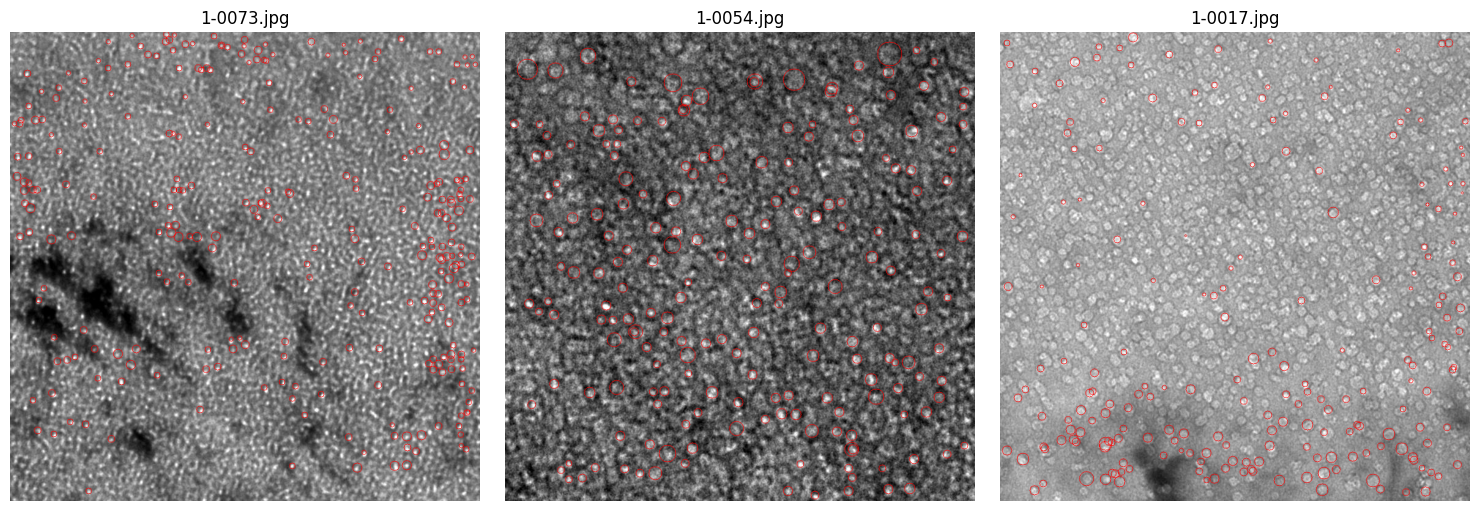

所有处理结果已保存到 /kaggle/working/circles


In [7]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# Create dictionary to store results
results_dict = {}

OUTPUT_PATH = '/kaggle/working/circles'
os.makedirs(OUTPUT_PATH, exist_ok=True)  # Create output folder if it doesn't exist

# Get all image files in the folder
image_files = [f for f in os.listdir(IMAGE_PATH) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Calculate number of rows needed to display all images
num_images = len(image_files)
num_cols = 3  
num_rows = (num_images + num_cols - 1) // num_cols

# Create figure
plt.figure(figsize=(15, 5*num_rows))

# Process each image
for idx, image_file in enumerate(image_files):
    # Read image
    im = cv2.imread(os.path.join(IMAGE_PATH, image_file))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)  # Convert color space from BGR to RGB
    
    # Use predictor to make predictions
    outputs = predictor(im)
    
    # Get masks and store in dictionary
    masks = outputs['instances'].pred_masks.cpu().numpy()
    results_dict[image_file] = masks
    
    # Create blank canvas same size as original image for drawing circles
    result = im.copy()
    
    # Find minimum enclosing circle for each mask and draw
    for mask in masks:
        # Convert mask to 8-bit integer type
        mask_8u = mask.astype(np.uint8) * 255
        
        # Find contours
        contours, _ = cv2.findContours(mask_8u, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Find minimum enclosing circle for each contour
        for contour in contours:
            (x, y), radius = cv2.minEnclosingCircle(contour)
            center = (int(x), int(y))
            radius = int(radius)
            
            # Draw red circle
            cv2.circle(result, center, radius, (255, 0, 0), 1)  # Red in RGB is (255,0,0)
    
    # Save result image to output folder
    output_file_path = os.path.join(OUTPUT_PATH, image_file)
    result_bgr = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)  # Convert back to BGR for saving
    cv2.imwrite(output_file_path, result_bgr)
    
    # Display image in subplot
    plt.subplot(num_rows, num_cols, idx + 1)
    plt.imshow(result)
    plt.title(image_file)
    plt.axis('off')

# Adjust spacing between subplots
plt.tight_layout()
plt.show()

print(f"All processing results have been saved to {OUTPUT_PATH}")

## 2.GCM step

In [8]:
##hyparamaters

blocksize_range_down,blocksize_range_up = 3,139
C_list_range_down,C_list_range_up = -95,-5
pixel_limits_range_range_down,pixel_limits_range_range_up = 1,160
thresh_2_range_down,thresh_2_range_up = 30,250
tileGridSize_range_down,tileGridSize_range_up = 1,60
blurred_range_down,blurred_range_up = 1,23

k = 2 
lr = 0.3
weight = 1
epoch = 10
batchsize = 100
lower_limit = 500
upper_limit = 2000
match_limit_num = 60
data_folder = '/kaggle/input/shottest/Shottest/image'
annotation_folder = '/kaggle/input/shottest/Shottest/labels/5-shot'

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

match_limit =  62.0
0.95
0/10


  0%|          | 0/100 [00:00<?, ?it/s]

match_limit =  64.0
0.87
1/10


  0%|          | 0/100 [00:00<?, ?it/s]

match_limit =  66.0
0.030000000000000027
2/10


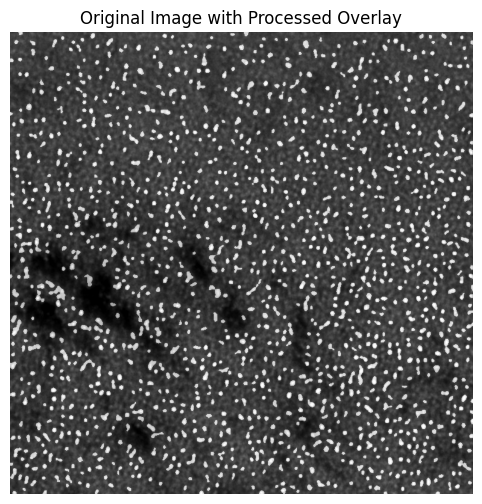

  0%|          | 0/100 [00:00<?, ?it/s]

match_limit =  62.0
0.8
0/10


  0%|          | 0/100 [00:00<?, ?it/s]

match_limit =  64.0
0.0
1/10


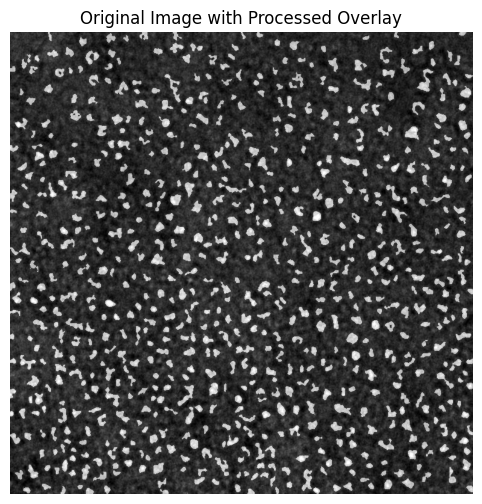

  0%|          | 0/100 [00:00<?, ?it/s]

match_limit =  62.0
0.9299999999999999
0/10


  0%|          | 0/100 [00:00<?, ?it/s]

match_limit =  64.0
0.83
1/10


  0%|          | 0/100 [00:00<?, ?it/s]

match_limit =  66.0
0.31999999999999995
2/10


  0%|          | 0/100 [00:00<?, ?it/s]

match_limit =  68.0
0.30000000000000004
3/10


  0%|          | 0/100 [00:00<?, ?it/s]

match_limit =  70.0
0.39
4/10


  0%|          | 0/100 [00:00<?, ?it/s]

match_limit =  72.0
0.22999999999999998
5/10


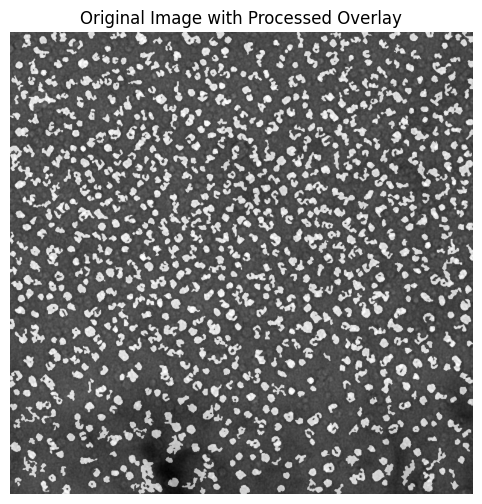

In [9]:
import os
import matplotlib.pyplot as plt
import numpy as np


def same_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
same_seeds(23333)     

# image_paths = []
for root, directories, files in os.walk(data_folder):
    for name in tqdm(files):
        if name.endswith((".jpg", ".png")):
            match_limit = match_limit_num
            path = (os.path.join(root, name))

            gcm = GCM(path=path,label_dir = annotation_folder)
            a, b, c, d, e, f = gcm.train(epoch=epoch,
                                   batchsize=batchsize,
                                   lower_limit=lower_limit,
                                   upper_limit=upper_limit,
                                   learning_rate=lr,
                                   weight=weight,
                                   blocksize_range_down=blocksize_range_down,
                                   blocksize_range_up=blocksize_range_up,
                                   C_list_range_down=C_list_range_down,
                                   C_list_range_up=C_list_range_up,
                                   pixel_limits_range_range_down=pixel_limits_range_range_down,
                                   pixel_limits_range_range_up=pixel_limits_range_range_up,
                                   blurred_range_down = blurred_range_down,
                                   blurred_range_up=blurred_range_up,
                                   thresh_2_range_down = thresh_2_range_down,
                                   thresh_2_range_up = thresh_2_range_up,
                                   tileGridSize_range_down = tileGridSize_range_down,
                                   tileGridSize_range_up = tileGridSize_range_up                                                                            
                                   )
            g, label,match = gcm.shape_Detection(a, b, c, d, e, f)
            
            # print(g , match)
            
            labelimg = Image.fromarray(label)

            save_dir = "/kaggle/working/output"
            
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
            filename = os.path.basename(path)  
            filename_without_ext = os.path.splitext(filename)[0]  
            save_path = os.path.join(save_dir, f"{filename_without_ext}.png") 

            # Save the processed image
            labelimg.save(save_path)

            # Display the original image and the processed image
            # Define the original image
            original_img = cv2.imread(path)

            # Define the processed image
            processed_img = cv2.imread(save_path)

            # Convert the images to grayscale
            original_gray = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
            processed_gray = cv2.cvtColor(processed_img, cv2.COLOR_BGR2GRAY)

            # Convert the grayscale images to floating-point arrays
            original_gray = original_gray.astype(np.float32)
            processed_gray = processed_gray.astype(np.float32)

            # Create a weighted average of the two images
            overlay = cv2.addWeighted(original_gray, 0.5, processed_gray, 0.5, 0)

            # Convert the overlay back to a uint8 array
            overlay = overlay.astype(np.uint8)

            # Display the overlay
            fig, ax = plt.subplots(figsize=(12, 6))
            ax.imshow(overlay, cmap='gray')
            ax.set_title('Original Image with Processed Overlay')
            ax.axis('off')

            plt.show()

## 3.Model ensemble

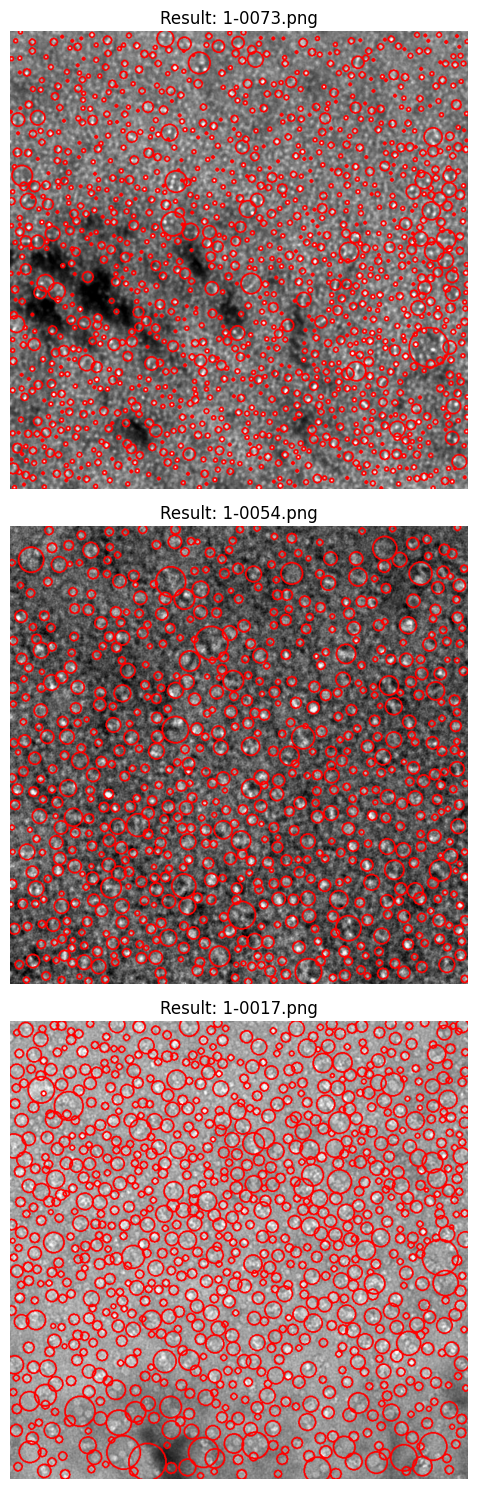

In [37]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt


# Define output directory
save_dir = '/kaggle/working/output'  # Directory to store images
os.makedirs(save_dir, exist_ok=True)

# Get all image files in the save directory (assuming images are in .png/.jpg/.jpeg format)
image_files = [f for f in os.listdir(save_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Calculate the number of rows needed to display all images
num_images = len(results_dict)
num_cols = 1  # Display 1 column
num_rows = num_images  # One row per image

# Create figure
plt.figure(figsize=(5, 5 * num_rows))

# Process each image
for idx, result_file in enumerate(results_dict.keys()):
    # Replace result file extension with possible image extensions
    base_name = os.path.splitext(result_file)[0]  # Remove extension
    image_file = None

    # Search for matching image file in save directory
    for ext in ['.png', '.jpg', '.jpeg']:
        possible_file = f"{base_name}{ext}"
        if possible_file in image_files:
            image_file = possible_file
            break

    if image_file is None:
        print(f"No image found for result {result_file}, skipping...")
        continue

    # Load corresponding image
    im_path = os.path.join(save_dir, image_file)
    im = cv2.imread(im_path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    _, im_binary = cv2.threshold(im, 127, 255, cv2.THRESH_BINARY)  # Convert to binary

    # Get corresponding masks
    masks = results_dict[result_file]

    # Skip if no masks found
    if masks.size == 0:
        print(f"No masks found for image {result_file}, skipping...")
        continue

    # Combine all masks into a single image
    combined_mask = np.sum(masks, axis=0)  # Stack all object masks
    combined_mask = np.clip(combined_mask, 0, 1)  # Ensure pixel values are in [0, 1]
    combined_mask = (combined_mask * 255).astype(np.uint8)  # Convert to binary

    # Copy image for result overlay
    result_overlay = cv2.add(im_binary, combined_mask)  # Add binary images
    _, result_overlay_binary = cv2.threshold(result_overlay, 127, 255, cv2.THRESH_BINARY)  # Convert to binary
    result_overlay_rgb = cv2.cvtColor(result_overlay_binary, cv2.COLOR_GRAY2RGB)  # Convert to RGB

    result_mask = cv2.imread(f'/kaggle/input/shottest/Shottest/image/{result_file}')

    # Find all connected components in the added image
    contours, _ = cv2.findContours(result_overlay_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find minimum enclosing circle for each connected component and draw
    for contour in contours:
        (x, y), radius = cv2.minEnclosingCircle(contour)
        center = (int(x), int(y))
        radius = int(radius)

        # Draw red circle on the overlay image
        cv2.circle(result_mask, center, radius, (255, 0, 0), 2)  # Line width 2 pixels

    # Display only the result image
    plt.subplot(num_rows, num_cols, idx + 1)
    plt.imshow(result_mask)
    plt.title(f"Result: {image_file}")
    plt.axis('off')

# Adjust spacing between subplots
plt.tight_layout()
plt.show()